# Atividade 4
Realizar a segmentação dos pulmões através de uma imagem de radiografia, utilizando as técnicas estudadas

### Importação das bibliotecas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

C:\Users\danil\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\danil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\danil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


### Funções utilizadas

In [4]:
#função para equalizar histograma
def equalizarHist(img):
    vet = histograma(img)
    s = np.zeros((1,256), dtype=int)[0]
    for k in range(0,256):
        Tk = 0
        for j in range(0,k):
            pk = vet[j]/(img.shape[0] * img.shape[1])
            Tk = Tk + pk
        
        s[k] = Tk*255
        img_e = s[img.flatten()]
        im_saida = np.reshape(img_e, img.shape)
    
    return im_saida

#função para transformação logarítmica
def transLog(X):
    c = 255 / np.log(1 + np.max(X))
    log_image = c * (np.log(X + 1))
    
    log_image = np.array(log_image, dtype = np.uint8)
    return log_image

#função para correção gamma
def gamma(X, g):
    imgOut = np.array(255*(img / 255) ** g, dtype = 'uint8')
    
    return imgOut

def limiar(X, t):
    imgOut = np.zeros(img.shape)
    imgOut[np.where(img_media > t)] = 255
    
    return imgOut

#função para filtro da média
def filtroMedia(X, size):
    imgOut = X.copy()

    for i in range(size, X.shape[0]-size):
        for j in range(size, X.shape[1]-size):
            subI = X[i-size:i+size+1, j-size:j+size+1]
            m = np.mean(subI)
            imgOut[i][j] = int(m)
    return imgOut

#obter região do tórax
def regTorax(X):
    imgOut = X.copy()
    imgOut[0:80,imgOut.shape[1]-120:imgOut.shape[1]] = 0
    
    for j in range(0, X.shape[1]):
        if(imgOut[0,j]) == 0:
            pos = np.where(imgOut[:,j] == 255)
            if pos[0].size > 0:
                imgOut[pos[0][0]:imgOut.shape[0], j] = 255
        else:
            imgOut[0:imgOut.shape[0], j] = 255
    
    return imgOut

#obter pulmões
def regPulmonar(X, img_torax):
    img_l2 = limiar(X, 140)
    subInf = img_l2[850:img_l2.shape[0], 0:img_l2.shape[1]]
    
    img_l3 = limiar(X, 138)
    subSup = img_l3[0:170, 0:img_l3.shape[1]]
    
    img_l4 = limiar(X, 159)
    img_l4[850:img_l4.shape[0], 0:img_l4.shape[1]] = subInf
    img_l4[0:170, 0:img_l4.shape[1]] = subSup
    img_l4[np.where(img_torax == 0)] = 255
    
    return img_l4

# função de adjacência-4
def adj4(i, j, img, imgOut, newPixels):
    if img[i,j-1] == 1 and imgOut[i,j-1] == 0:
        imgOut[i,j-1] = 1
        newPixels = newPixels + 1
    if img[i,j+1] == 1 and imgOut[i,j+1] == 0:
        imgOut[i,j+1] = 1
        newPixels = newPixels + 1
    if img[i-1,j] == 1 and imgOut[i-1,j] == 0:
        imgOut[i-1,j] = 1
        newPixels = newPixels + 1
    if img[i+1,j] == 1 and imgOut[i+1,j] == 0:
        imgOut[i+1,j] = 1
        newPixels = newPixels + 1
    return newPixels

# detectar regiões de conexão
def connectRegions(img, x, y):
    img2 = np.zeros(np.shape(img))
    img2[np.where(img == 0)] = 1
    img2[np.where(img == 255)] = 0
    
    imgOut = np.zeros(np.shape(img))
    imgOut[x,y] = 1
    newPixels = 101
    newPixels2 = 0
    while newPixels>0:
        newPixels = 0
        newPixels2 = 0
        for i in range(1, np.shape(img)[0]-1):
            for j in range(1, np.shape(img)[1]-1):
                if imgOut[i,j] == 1:
                    newPixels = newPixels + adj4(i, j, img2, imgOut, newPixels2)
                    
        for i in range(np.shape(img)[0]-2, 1, -1):
            for j in range(1, np.shape(img)[1]-1):
                if imgOut[i,j] == 1:
                    newPixels = newPixels + adj4(i, j, img2, imgOut, newPixels2)
        #cv2.imshow('saida', imgOut)
        #cv2.waitKey(0)
        
    return imgOut

def removerRegioes(X):
    imgOut = X.copy()
    pos = np.where(imgOut[10,:] == 0)
    while pos[0].size > 0:
        Regiao = connectRegions(imgOut, 10, pos[0][0])
        imgOut[np.where(Regiao == 1)] = 255
        pos = np.where(imgOut[10,:] == 0)
        
    pos = np.where(imgOut[:,imgOut.shape[1]-5] == 0)
    
    if pos[0].size > 0:
        Regiao = connectRegions(imgOut, pos[0][0], imgOut.shape[1]-5)
        imgOut[np.where(Regiao == 1)] = 255
        pos = np.where(imgOut[:,imgOut.shape[1]-5] == 0)
    
    imgOut[imgOut.shape[0]-70:imgOut.shape[0], :] = 255
    imgOut[:, imgOut.shape[1]-20:imgOut.shape[1]] = 255
    imgOut[:,0:15] = 255
    
    return imgOut
    

### Principal

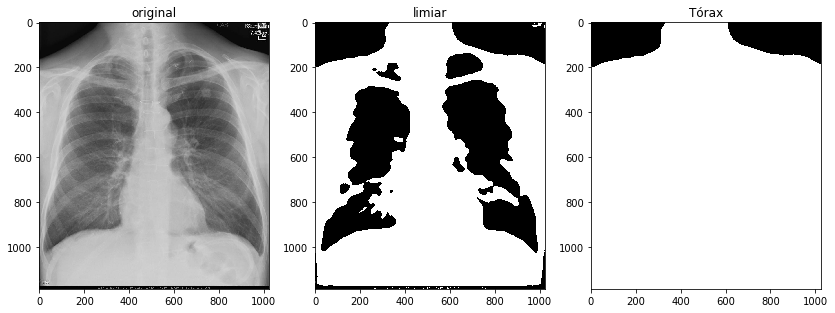

In [5]:
#leitura da imagem
img = cv2.imread('test images/radiografia.jpg', cv2.IMREAD_GRAYSCALE)

img_media = filtroMedia(img, 11)

#calcula o limiar
img_l1 = limiar(img_media, 120)

#obter região do tórax
img_torax = regTorax(img_l1)

fig = plt.figure()

fig.set_figheight(14)
fig.set_figwidth(14)

fig.add_subplot(1,3,1, title='original')
plt.imshow(img, cmap='gray')

fig.add_subplot(1,3,2, title='limiar')
plt.imshow(img_l1, cmap='gray')

fig.add_subplot(1,3,3, title='Tórax')
plt.imshow(img_torax, cmap='gray')



plt.show()

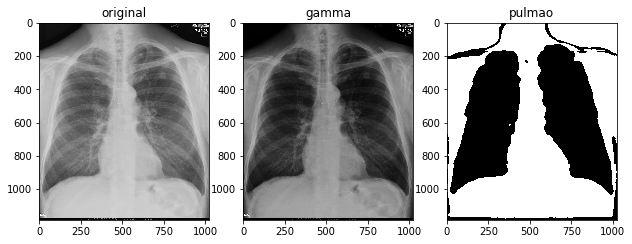

In [269]:

#correção gama na média
img_g = gamma(img_media,2)

#obter pulmões
img_pulmao = regPulmonar(img_media, img_torax)

fig = plt.figure()

fig.set_figheight(14)
fig.set_figwidth(14)

fig.add_subplot(1,3,1, title='original')
plt.imshow(img, cmap='gray')

fig.add_subplot(1,3,2, title='gamma')
plt.imshow(img_g, cmap='gray')

fig.add_subplot(1,3,3, title='pulmao')
plt.imshow(img_pulmao, cmap='gray')


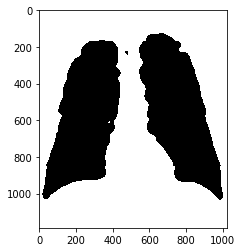

In [272]:
pulmao = removerRegioes(img_pulmao)
plt.imshow(pulmao, cmap='gray')

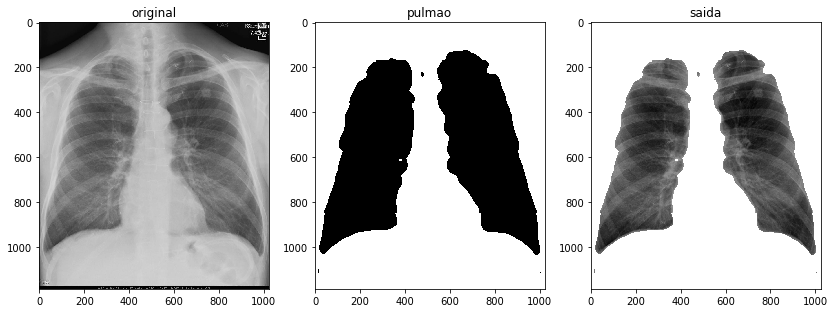

In [282]:
saida = img.copy()
saida[np.where(pulmao == 255)] = 255

fig = plt.figure()

fig.set_figheight(14)
fig.set_figwidth(14)

fig.add_subplot(1,3,1, title='original')
plt.imshow(img, cmap='gray')

fig.add_subplot(1,3,2, title='pulmao')
plt.imshow(pulmao, cmap='gray')

fig.add_subplot(1,3,3, title='saida')
plt.imshow(saida, cmap='gray')